##### **Contexto del set de datos Skin Segmentation**

El set de datos Skin Segmentation es producto de un muestreo aleatorio de valores RGB de imágenes de rostros de personas de distintos grupos de edad y origen racial obtenidas de bases como FERET y PAL. Del total de registros disponibles, no todos corresponden a piel. De acuerdo con la documentación de este set de datos, 50.859 registros corresponden a muestras de piel, y 194.198 corresponden a muestras que no son piel.

El set de datos cuenta con 245.057 registros y 4 columnas, 3 de las columnas corresponden a valores B, G y R y una columna corresponde a la variable de clase.

Antes de listar las variables es conveniente tener en cuenta que RGB es un modelo de color basado en composición de color a través de intensidad de los colores rojo, verde y azul. Dentro de este sistema los rangos de intesidad de los colores van de 0 a 255, por lo que las variables disponibles en este dataset tienen tal rango.

R -> Corresponde a la intensidad del color rojo. Es un valor númerico discreto entre 0 y 255.

G -> Corresponde a la intensidad del color verde. Es un valor númerico discreto entre 0 y 255.

B -> Corresponde a la intensidad del color azul. Es un valor númerico discreto entre 0 y 255.

C-> Corresponde a la **variable clase**, en este caso una de las clases corresponde a muestras que representan piel, y las otras muestra que no corresponden a piel.  

La finalidad de analizar este set de datos es entrenar un modelo de regresión logistica que permita clasificar correctamente las muestras de imagen que correspondan a piel.


##### **Carga de librerias y del set de datos**

El primer paso, es cargar las librerías y set de datos requerido para realizar el modelo.

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
import scipy as stats
from sklearn.metrics import f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score

In [ ]:
### Carga del archivo a partir de URL

source_url= "https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt"

## Al revisar el set de datos en el sitio de origen se puede apreciar que el set de datos no contiene valores nulos, por lo tanto no se configura el parametro na_values.
## Unicamente se configura el parámetro sep dado que los datos estan separados por tabulaciones

skin_df = pd.read_csv(source_url,header=None,sep='\t')

## Se procede a asignar los headers a las columnas de acuerdo a los nombres demarcados por la documentación del set de datos, en este caso no se hace directamente un
## reemplazo de la variable clase dado que se desconoce a priori cual corresponde a skin y cual a non-skin, para poder hacer este cambio es necesario contar los
## registros, una vez se tenga tal conteo siguiendo la documentación del dataset se pueden realizar los reemplazos

header_tags= ["B","G","R","C"]
skin_df .columns= header_tags

print(skin_df.head(10),"\n")
print("La distribución de las categorias de la variable C son: \n",skin_df["C"].value_counts(),"\n")
print(f"El conjunto de datos tiene {skin_df.shape[0]} registros y {skin_df.shape[1]} variables")

    B   G    R  C
0  74  85  123  1
1  73  84  122  1
2  72  83  121  1
3  70  81  119  1
4  70  81  119  1
5  69  80  118  1
6  70  81  119  1
7  70  81  119  1
8  76  87  125  1
9  76  87  125  1 

La distribución de las categorias de la variable C son: 
 2    194198
1     50859
Name: C, dtype: int64 

El conjunto de datos tiene 245057 registros y 4 variables


Se puede apreciar que la clase 2 tiene 194.198 registros, y la clase 1 tiene 50.859, teniendo en cuenta la documentación del set de datos la clase skin tiene 50.859 registros por lo tanto debe será la clase 1 y 2 será la clase 0, en la siguiente línea de código se aplica la modificación:

In [ ]:
skin_df["C"]= skin_df["C"].replace(2,0)
print("La distribución de las categorias de la variable C ahora son: \n",skin_df["C"].value_counts(),"\n")

La distribución de las categorias de la variable C ahora son: 
 0    194198
1     50859
Name: C, dtype: int64 



Con la lectura de datos concluida y con el ajuste de la variable clase, se puede proceder con el análisis exploratorio del set de datos.

##### **Exploración del set de datos**

Inicialmente se valida que las variables tengan un tipo de variable correcto:

In [ ]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   C       245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


Se puede apreciar claramente que las variables se encuentran en formato tipo integer, lo cual es consistente teniendo en cuenta que la escala RGB es discreta (comprende números enteros) y que además la variable clase es de carácter binario y por ende de carácter entero tomando valores entre 0 y 1.

Adicionalmente es relevante resaltar que este es un set de datos desbalanceado en donde la clase 1 representa un 20.75% y la clase 0 un 79,24%.

Con la claridad respecto al formateo de las variables, y la proporción de las clases se procede a realizar un análisis univariado y bivariado:

###### **Análisis univariado**

Inicialmente se revisan los estadisticos básicos asociados a las variables explicativas disponibles:

In [ ]:
skin_df[["R","G","B"]].describe()

,R,G,B
count,245057.000000,245057.000000,245057.000000
mean,123.177151,132.507327,125.065446
std,72.562165,59.941197,62.255653
min,0.000000,0.000000,0.000000
25%,70.000000,87.000000,68.000000
50%,128.000000,153.000000,139.000000
75%,164.000000,177.000000,176.000000
max,255.000000,255.000000,255.000000


Al revisar los estadísticos básicos se puede apreciar que todas las variables tienen un valor máximo de 255 lo cual resultan consistente y es evidencia suficiente para decir que no hay presencia de datos atípicos, esto teniendo en cuenta que el rango de las variables comprenden números entre 0 y 255. Además, se puede apreciar que para todos los casos la mediana (percentil 50) es mayor a la media por lo tanto estas variables presentan un leve sesgo a la izquierda. Para tener mayor claridad respecto al aspecto de la distribución de las variables, se procede a proponer visualizaciones que permitan apreciar las distribuciones:

Text(0.5, 0.98, 'Distribuciones de las variables R, G y B - Representadas en histograma y diagrama de caja')

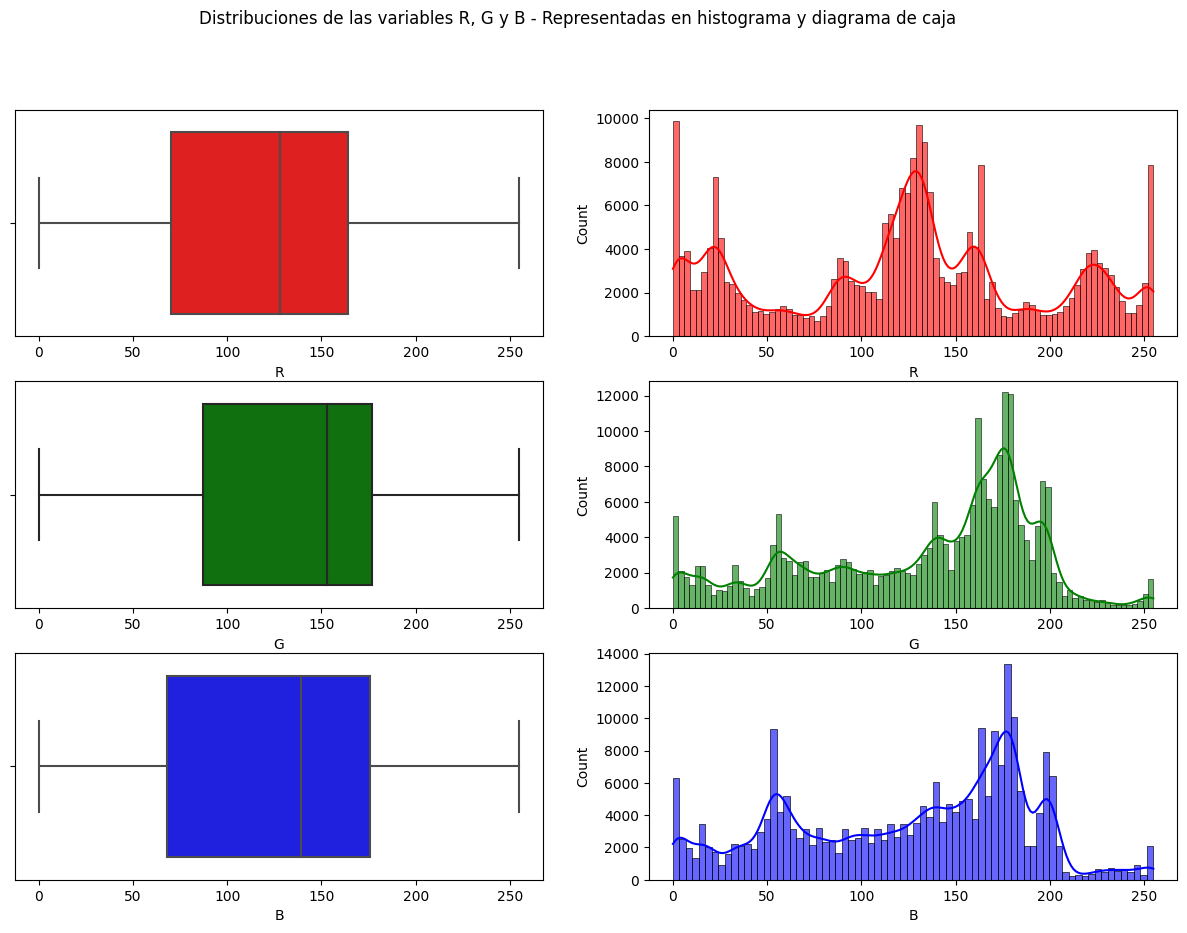

In [ ]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(15, 10))

sns.boxplot(ax=ax[0,0], x= "R", data=skin_df,color="red")
sns.histplot(ax=ax[0,1], x= "R", data=skin_df,kde=True,color="red",alpha=0.6)


sns.boxplot(ax=ax[1,0], x= "G",data=skin_df,color="green")
sns.histplot(ax=ax[1,1], x= "G", data=skin_df,kde=True,color="green",alpha=0.6)

sns.boxplot(ax=ax[2,0], x= "B", data=skin_df,color="blue")
sns.histplot(ax=ax[2,1], x= "B", data=skin_df,kde=True,color="blue",alpha=0.6)

plt.suptitle('Distribuciones de las variables R, G y B - Representadas en histograma y diagrama de caja',fontsize=12)

Al revisar las gráficas de las variables se puede apreciar claramente la asimetria a la izquierda especialmente al observar los histogramas, y además se posible apreciar que efectivamente no la distribución de cada variable está dentro de los límites normales sin presentar valores por encima de su rango y a su vez evidenciando ausencia de outliers en sus distribuciones.

Ahora se procede a hacer un análisis de la asimetría de la distribución con el coeficiente de Fisher, la curtosis de la distribución y la prueba Anderson-Darling para las 3 variables explicativas. Lo cual permite evidenciar la asimetría en los datos y que no siguen parámetros de normalidad.

In [ ]:
from scipy.stats import skew
print("La asimetría de la distribución se define por el valor calculado con el coeficiente de Fisher pearson para la asimetría: \n",skew(skin_df[["R","G","B"]], axis=0, bias=True))

#Skewness = 0: Then normally distributed.
#Skewness > 0: Then more weight in the left tail of the distribution.
#Skewness < 0: Then more weight in the right tail of the distribution.


from scipy.stats import kurtosis
print("La curtosis de la distribución se define por el valor calculado con \n",kurtosis(skin_df[["R","G","B"]], axis=0, bias=True),"\n")
#kurtosis for normal distribution is equal to 3.
#For a distribution having kurtosis < 3: It is called playkurtic.
#For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution.

from scipy.stats import anderson

data = skin_df[["R", "G", "B"]].to_numpy()

alpha = 0.05

for i in range(data.shape[1]):
    vector = data[:, i]
    # prueba Anderson-Darling al 5%
    result = anderson(vector, dist='norm')
    print(f"Resultados para el vector {i+1} (valor crítico del 5%): ")
    print(f"Estadístico de prueba: {result.statistic:.2f}")
    print(f"Valores críticos: {result.critical_values}")
    print(f"Nivel de significancia: {result.significance_level:}")
    if result.statistic > result.critical_values[2]:
        print("Los datos no siguen una distribución normal","\n")
    else:
        print("Los datos siguen una distribución normal","\n")

La asimetría de la distribución se define por el valor calculado con el coeficiente de Fisher pearson para la asimetría: 
 [-0.03767122 -0.62174336 -0.34265445]
La curtosis de la distribución se define por el valor calculado con 
 [-0.86489461 -0.60120119 -0.91547697] 

Resultados para el vector 1 (valor crítico del 5%): 
Estadístico de prueba: 2890.38
Valores críticos: [0.576 0.656 0.787 0.918 1.092]
Nivel de significancia: [15.  10.   5.   2.5  1. ]
Los datos no siguen una distribución normal 

Resultados para el vector 2 (valor crítico del 5%): 
Estadístico de prueba: 7184.42
Valores críticos: [0.576 0.656 0.787 0.918 1.092]
Nivel de significancia: [15.  10.   5.   2.5  1. ]
Los datos no siguen una distribución normal 

Resultados para el vector 3 (valor crítico del 5%): 
Estadístico de prueba: 4643.34
Valores críticos: [0.576 0.656 0.787 0.918 1.092]
Nivel de significancia: [15.  10.   5.   2.5  1. ]
Los datos no siguen una distribución normal 



###### **Análisis bivariado**

A continuación se revisan los estadísticos básicos para cada clase, para esto se realiza una transformación provisional convirtiendo la variable C en category.

In [ ]:
skin_bivar = skin_df.copy()
skin_bivar["C"] = skin_bivar["C"].astype("category")

In [ ]:
bivar_stats= skin_bivar.groupby(["C"])[["R","G","B"]].agg(["mean","max","min","median","std"]).T
bivar_stats

C                  0           1
R mean    102.012364  203.991938
  max     255.000000  255.000000
  min       0.000000  106.000000
  median  115.000000  218.000000
  std      64.137892   37.696602
G mean    128.816270  146.601113
  max     255.000000  230.000000
  min       0.000000   56.000000
  median  154.000000  152.000000
  std      64.279618   35.840314
B mean    127.997482  113.869876
  max     255.000000  225.000000
  min       0.000000   26.000000
  median  151.000000  117.000000
  std      66.301507   41.612799

Al revisar los estadísticos básicos comparados para cada clase se pueden apreciar varios elementos relevantes:

- Los registros que corresponden a piel tienen una intensidad de R mínima de 106 llegando a máximos de hasta 255. De acuerdo con esto, un registro que corresponda a piel no presentará intensidades de rojo inferiores a 106.

- Los registros que corresponden a piel tienen una intensidad de G mínima de 56 llegando a máximos de 230. Por lo tanto los registros que no corresponden a piel presentan intensidades mayores a 230 y menores a 56.

- Los registros que corresponden a piel tienen una intensidad de B mínima de 26 y máxima de 225. De acuerdo con esto un registro que corresponda a piel no presentará intensidades de azul inferiores a 26 ni mayores a 225.

Ahora veamos las distribuciones de forma gráfica


<Axes: xlabel='B', ylabel='Count'>

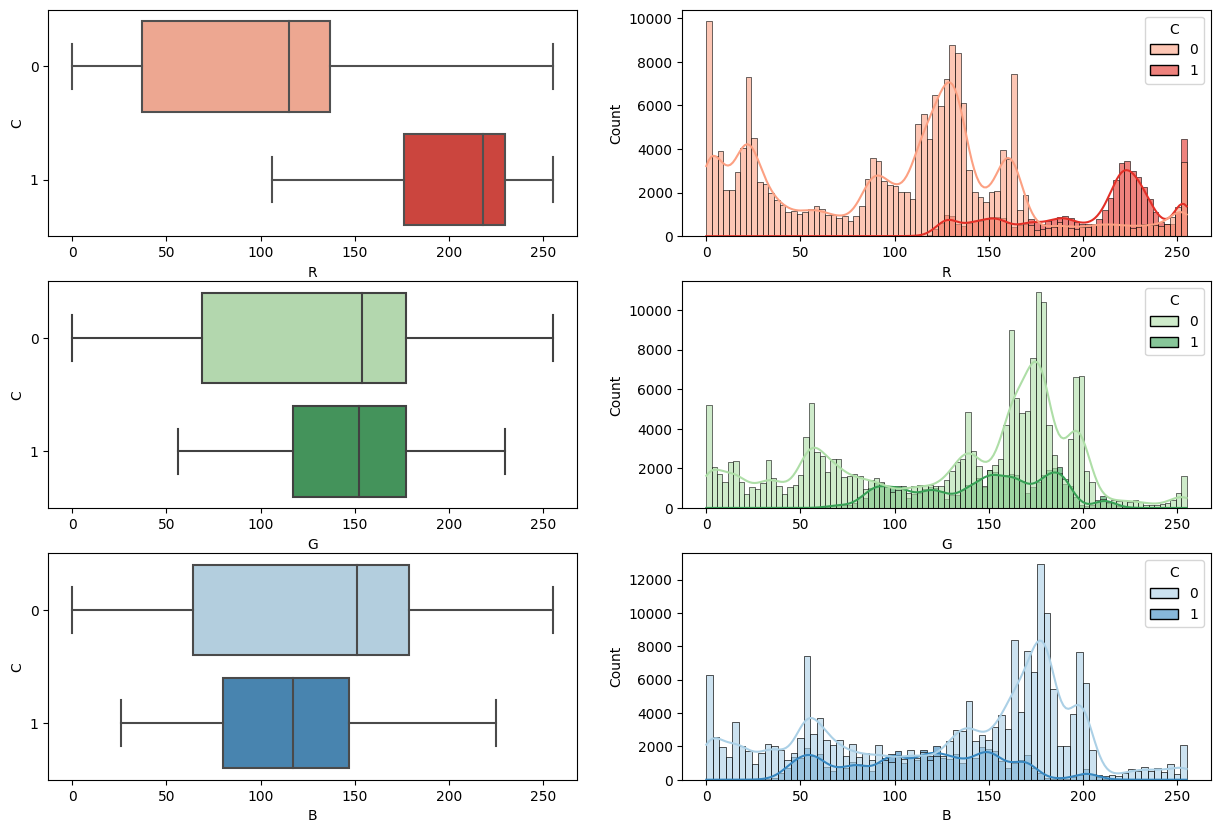

In [ ]:
fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(15, 10))

sns.boxplot(ax=ax[0,0], x= "R",y="C", data=skin_bivar,palette="Reds")
sns.histplot(ax=ax[0,1], x= "R",hue="C" ,data=skin_bivar,kde=True,palette="Reds",alpha=0.6)


sns.boxplot(ax=ax[1,0], x= "G",y="C",data=skin_bivar,palette="Greens")
sns.histplot(ax=ax[1,1], x= "G",hue="C", data=skin_bivar,kde=True,palette="Greens",alpha=0.6)

sns.boxplot(ax=ax[2,0], x= "B",y="C", data=skin_bivar,palette="Blues")
sns.histplot(ax=ax[2,1], x= "B",hue="C", data=skin_bivar,kde=True,palette="Blues",alpha=0.6)

La visualización de las distribuciones discriminadas por la clase permiten confirmar con mucha más claridad los elementos relevantes hallados al revisar los estadísticos. En general los registros relacionados con piel tienen rangos de intensidades de color acotados que se presentan como subconjuntos del rango total de la intensidad de cada color. Esto resulta ser una ventaja ya que los pixeles relacionados a piel tienen atributos claramente diferenciados que pueden conducir a que el proceso de predicción pueda llegar a ser mucho más preciso.  

Como último ejercicio de análisis bivariado se procede a revisar si existen correlaciones elevadas entre las variables cuantitativas:

<Axes: >

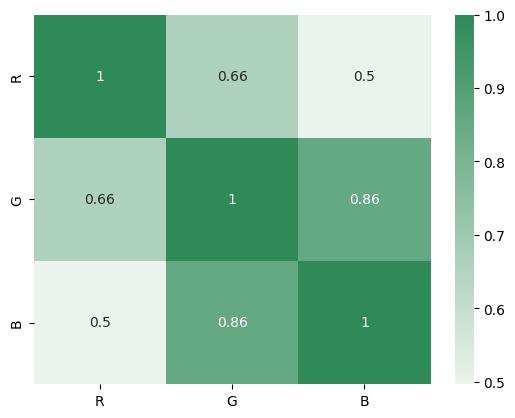

In [ ]:
sns.heatmap(skin_df[["R","G","B"]].corr(),annot=True,cmap=sns.light_palette("seagreen", as_cmap=True))

Se puede apreciar que las variables B y G tienen correlación lineal positiva fuerte, para validar si representan un problema de multicolinealidad se procede a calcular el VIF

In [ ]:

independent_var = skin_df[["B","G","R"]]

vif_df= pd.DataFrame()
vif_df["variable"]= independent_var.columns

vif_df["VIF"]= [variance_inflation_factor(independent_var,i) for i in range(len(independent_var.columns))]

print(vif_df)


  variable        VIF
0        B  19.080241
1        G  28.292612
2        R   6.942823


El cálculo de la matriz de correlaciones y el cálculo del VIF permite apreciar que efectivamente hay una alta correlación entre las variables explicativas B y G, y que ambas dan lugar a diagnosticar un nivel de multicolineaalidad elevado lo cual es una señal importante a tener en cuenta en la fase de preparación de los datos.  

Finalmente se valida la existencia de datos faltantes antes de pasar a la fase de preparación de los datos:

In [ ]:
skin_df.isnull().sum()

B    0
G    0
R    0
C    0
dtype: int64

Como se puede evidenciar el set de datos no tiene valores nulos, por lo tanto se prosigue con la fase de preparación en donde se contemplarán cuatro escenarios:

- Caso sin eliminación de datos correlacionados y sin balanceo
- Caso sin eliminación de datos correlacionados y con balanceo
- Caso con eliminación de datos correlacionados y sin balanceo
- Caso con eliminación de datos correlacionados y con balanceo

##### **Preparación de los datos**

En esta sección únicamente se generarán dos dataset, uno sin variables correlacionadas y uno con variables correlacionadas. Las demás transformaciones asociadas al balanceo se harán previamente al proceso de modelado con el fin de ejecutar cambios únicamente en el set de entrenamiento y no alterar el dataset de prueba

**Dataset con datos correlacionados**:

En este caso el set de datos no tiene resuelto el problema de multicolinealidad ya que se conservan G y B

In [ ]:


skin_corr_df= skin_df.copy()

skin_corr_df.head()

,B,G,R,C
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


**Dataset sin datos correlacionados:**

En este caso se omite la variable G la cual al aplicar VIF cuenta con un valor de 28 que representa multicolinealidad alta


In [ ]:
skin_no_corr_df= skin_df[["R","B","C"]].copy()

skin_no_corr_df.head()

,R,B,C
0,123,74,1
1,122,73,1
2,121,72,1
3,119,70,1
4,119,70,1


#### **Modelación y Evaluación**

##### **Escenario 1 - Regresión Logistica sin eliminación de datos correlacionados y sin balanceo**

Con fines de observación primero se entrena un modelo con semilla aleatoria fija con el fin de conocer sus métricas iniciales, las proporción para el set de entrenamiento será una muestra aleatoria del 70% de los datos, y el set de test corresponde al 30% restante

**Partición de los datos en train y test**

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(skin_corr_df.drop('C', axis=1), skin_corr_df.C, test_size=0.30,random_state=42)

print(f"El dataset de entrenamiento cuenta con {X_train1.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train1.value_counts()[1]} ({round((y_train1.value_counts()[1]/X_train1.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train1.value_counts()[0]} ({round((y_train1.value_counts()[0]/X_train1.shape[0])*100,2)}%)  registros \n")

print(f"El dataset de test cuenta con {X_test1.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test1.value_counts()[1]} ({round((y_test1.value_counts()[1]/X_test1.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test1.value_counts()[0]} ({round((y_test1.value_counts()[0]/X_test1.shape[0])*100,2)}%)  registros \n")


El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35665 (20.79%) registros y la clase 0 corresponde a 135874 (79.21%)  registros 

El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15194 (20.67%) registros y la clase 0 corresponde a 58324 (79.33%)  registros 



El set de datos, en este caso, queda con 171.539 registros y con una distribución de clases en donde 1 20.79% y la clase 0 79.21%. Para el set de prueba se cuenta con 73.518 registros y con una distribución de clase 1 del 20.67% y la 0 79.33%.

**Entrenamiento del modelo**

En esta sección de entrenamiento se corre un primer modelo con semilla aleatoria con el fin de que sus resultados sean inmutables, la finalidad de esto es tener una primera referencia respecto al desempeño del modelo entrenado, las conclusiones derivadas de esta primera evaluación se refuerzan a partir de las secciones de evaluación con Randon Subsampling y n-folds.

In [ ]:

#Entrenamiento del modelo
logisticRegr1= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01,random_state=42)
logisticRegr1.fit(X_train1, y_train1)

#Predicción usando el modelo
predictions1 = logisticRegr1.predict(X_test1)

## Matriz de confusión
conf_matrix1 = confusion_matrix(y_test1,predictions1)

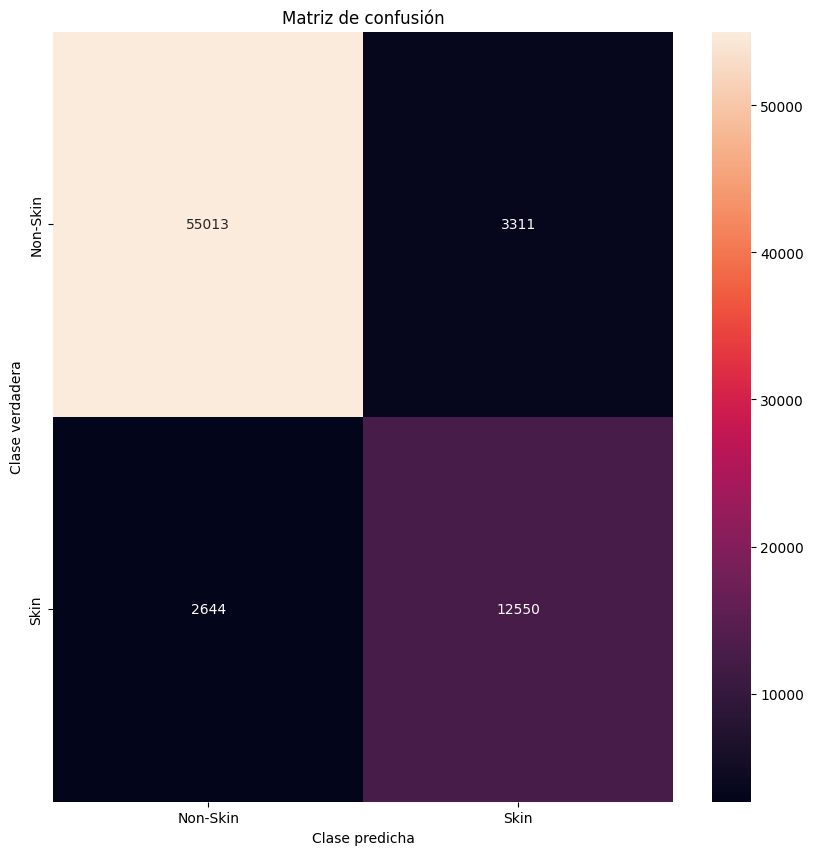

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     58324
           1       0.79      0.83      0.81     15194

    accuracy                           0.92     73518
   macro avg       0.87      0.88      0.88     73518
weighted avg       0.92      0.92      0.92     73518



In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix1, xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="d")
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()
print(classification_report(y_test1,predictions1))

Particularmente sklearn esta tomando como clase positiva a los casos "non-skin" y como clase negativa a los casos "skin", no obstante esto no genera mayores inconvenientes a nivel interpretativo, se puede observar que el modelo ha clasificado correctamente 12550 registros relacionados a skin, en medio de esto ha clasificado incorrectamente 3311 registros (falsos positivos) en este orden de ideas el modelo presenta una especificidad de 0.79, en lo que respecta a los casos "non-skin" se puede apreciar que el margen de error es menor. Bajo este primer ejercicio de observación es claro que el modelo entrenado tiene una buena capacidad de clasificación mostrando buen desempeño para la clasificación de ambas clases lo cual es consistente respecto a un macro-average de F1 equivalente a 0.88.

Para validar la certeza respecto al desempeño del modelo, en la sección siguiente se ejecuta random-subsampling y n-folds con el fin de conocer la consistencia de las métricas una vez se realizan varias iteraciones y validaciones cruzadas con intercalado de sets de entrenamiento y test en el caso de n-folds.

###### **Evaluación**

A continuación, se procede a hacer la evaluación del modelo con random subsampling con proporciones 70-30 y N-Folds con 10 splits.

**Randon Subsampling - Proporciones 70-30**

Inicialmente se crea una función para correr el random subsampling, para asegurar la proporción 70-30 se deja fijo el parámetro test_size con un valor 0.30.

In [ ]:
def random_subsp(dataset,iteraciones):

    accuracy_scores_list=[]
    confusion_mx_collection=[]
    TP_list=[]
    TN_list=[]
    FP_list=[]
    FN_list=[]
    precision_list=[]
    recall_list=[]
    F1_list=[]
    especificidad_list=[]
    iter_list=range(1,iteraciones+1)

    for element in iter_list:
        print("se inicia la iteración número",element,"\n")
        X_train, X_test, y_train, y_test = train_test_split(dataset.drop('C', axis=1), dataset.C, test_size=0.30)

        print("En la iteración número",element,f"El dataset de entrenamiento cuenta con {X_train.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train.value_counts()[1]} ({round((y_train.value_counts()[1]/X_train.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train.value_counts()[0]} ({round((y_train.value_counts()[0]/X_train.shape[0])*100,2)}%)  registros \n")
        print("En la iteración número",element,f"El dataset de test cuenta con {X_test.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test.value_counts()[1]} ({round((y_test.value_counts()[1]/X_test1.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test.value_counts()[0]} ({round((y_test.value_counts()[0]/X_test.shape[0])*100,2)}%)  registros \n")

        reglog= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
        reglog.fit(X_train, y_train)
        predictions = reglog.predict(X_test)

        conf_matrix = confusion_matrix(y_test,predictions)

        TP= conf_matrix[0][0]
        TN= conf_matrix[1][1]
        FP= conf_matrix[0][1]
        FN= conf_matrix[1][0]

        TP_list.append(TP)
        TN_list.append(TN)
        FP_list.append(FP)
        FN_list.append(FN)


        print("La clasificación realizada en esta iteración cuenta con", TP ," Verdadero Positivos", TN, " Verdaderos Negativos", FP," Falsos Positivos y ",FN," Falsos Negativos \n" )

        precision= TP/(TP+FP)
        recall= TP/(TP+FN)
        F1= (2*recall*precision)/(recall+precision)
        especificidad = TN/(TN+FP)

        precision_list.append(precision)
        recall_list.append(recall)
        F1_list.append(F1)
        especificidad_list.append(especificidad)

        print(f"Algunas métricas de la iteracion precision:{precision}, recall: {recall}, especificidad: {especificidad}, F1:{F1} \n")

        accuracy_model = accuracy_score(y_test, predictions)

        confusion_mx_collection.append(conf_matrix)
        accuracy_scores_list.append(accuracy_model)

    scores_array= np.asarray(accuracy_scores_list)
    mean_accu= np.mean(scores_array)
    std_accu= np.std(scores_array)

    TP_avg= np.mean(np.asarray(TP_list))
    TN_avg= np.mean(np.asarray(TN_list))
    FP_avg= np.mean(np.asarray(FP_list))
    FN_avg= np.mean(np.asarray(FN_list))

    conf_matrix_avg= np.array([[TP_avg,FP_avg],[FN_avg,TN_avg]])

    precision_avg= np.mean(np.asarray(precision_list))
    recall_avg= np.mean(np.asarray(recall_list))
    F1_avg= np.mean(np.asarray(F1_list))
    especificidad_avg= np.mean(np.asarray(especificidad_list))

    precision_std= np.std(np.asarray(precision_list))
    recall_std= np.std(np.asarray(recall_list))
    F1_std= np.std(np.asarray(F1_list))
    especificidad_std= np.std(np.asarray(especificidad_list))

    dict_metricas = {"precision":precision_avg,"precision_std":precision_std,"recall avg":recall_avg,"recall_std":recall_std,"specificity_avg":especificidad_avg,
                     "specificity_std":especificidad_std, "accuracy_avg":mean_accu,"accuracy_std":std_accu,"F1_avg":F1_avg,"F1_std":F1_std}

    metrics_resume_avg= pd.DataFrame(data=dict_metricas,index=[0])


    print("Después de ", iteraciones, " iteraciones el accuracy promedio es de",mean_accu, " y su desviación estándar es de + o - ",std_accu)

    tupla_final= (conf_matrix_avg,metrics_resume_avg,precision_avg,precision_std,recall_avg,recall_std,precision_std,F1_avg,F1_std,especificidad_avg,especificidad_std,mean_accu,std_accu)

    return tupla_final



Ahora, se aplica el random subsampling con la función diseñada para 10 iteraciones en el que se incluyen las métricas de precisión, recall y F1-score. Lo que da como resultado lo siguiente:

In [ ]:
evaluacion_metodo1 = random_subsp(skin_no_corr_df,10)

se inicia la iteración número 1 

En la iteración número 1 El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35649 (20.78%) registros y la clase 0 corresponde a 135890 (79.22%)  registros 

En la iteración número 1 El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15210 (20.69%) registros y la clase 0 corresponde a 58308 (79.31%)  registros 

La clasificación realizada en esta iteración cuenta con 54978  Verdadero Positivos 12422  Verdaderos Negativos 3330  Falsos Positivos y  2788  Falsos Negativos 

Algunas métricas de la iteracion precision:0.9428894834328051, recall: 0.951736315479694, especificidad: 0.7885982732351448, F1:0.9472922446025811 

se inicia la iteración número 2 

En la iteración número 2 El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35509 (20.7%) registros y la clase 0 corresponde a 13

Una vez aplicado el random subsampling se procede a generar la matriz de confusión promedio del proceso iterativo de evaluación:

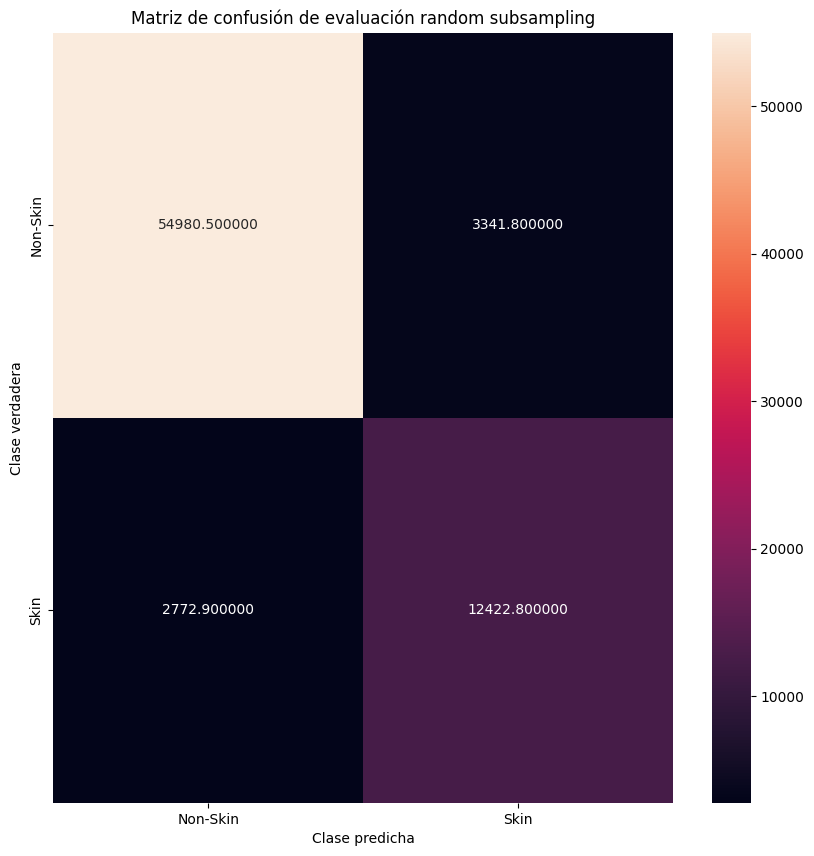

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(evaluacion_metodo1[0], xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="f")
plt.title("Matriz de confusión de evaluación random subsampling")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

In [ ]:
evaluacion_metodo1[1]

,precision,precision_std,recall avg,recall_std,especificity_avg,specificity_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.942701,0.001067,0.951988,0.000954,0.788033,0.002626,0.916827,0.000666,0.947321,0.000483


Al apreciar los resultados de random_subsampling se puede observar que el modelo despues de 10 iteraciones sigue conservando un nivel de especificidad cercano a los 0.78 y valores de recall y precision muy similares, el accuracy es levemente menor al reportado en el modelo entrenado inicialmente, bajo esta modalidad de evaluación se puede apreciar que las métricas del modelo con semilla aleatoria son consistentes.

**N-Folds Validation**

Inicialmente se crea una función para correr el N-folds validation, para esta función se usa cross_validate de sklearn, esta funcióm permite realizar el proceso de n-folds y habilita la generación de todas sus métricas, no obstaante no permite generar explicitamente una matriz de confusión, en este caso como output de evaluación se generan los valores promedio de las métricas del proceso iterativo.

In [ ]:
from sklearn.model_selection import cross_validate


def cross_validation(model, _X, _y, _cv=10):

      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=False)

      dict_metricas = {"precision":results['test_precision'].mean(),"precision_std":results['test_precision'].std(),"recall avg":results['test_recall'].mean(),"recall_std":results['test_recall'].std(),
                      "accuracy_avg":results['test_accuracy'].mean(),"accuracy_std":results['test_accuracy'].std(),"F1_avg":results['test_f1'].mean(),"F1_std":results['test_f1'].std()}

      metrics_resume_avg= pd.DataFrame(data=dict_metricas,index=[0])

      return metrics_resume_avg



Ahora se procede a realizar la validación N-Folds con N=10.

In [ ]:

X1= skin_corr_df[["R","G","B"]]
y1= skin_corr_df["C"]

reglog1= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)

evaluation_kfold1 = cross_validation(reglog1, X1, y1, _cv=10)



In [ ]:
evaluation_kfold1

,precision,precision_std,recall avg,recall_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.798878,0.160545,0.811011,0.191814,0.913873,0.056473,0.791845,0.141606


Al observar el n-folds con 10 splits se puede apreciar que el rendimiento del modelo no resulta ser tan bueno cuando se hace entrenamiento y test con secciones de los datos, esto evidencia que seguramente el desbalance de clases pero tambien sus puntos comunes están diezmando la consistencia cuando el modelo se enfrenta datos diferentes a los de entrenamiento.

Ahora, se procede a realizar el siguiente escenario sin datos correlacionados pero balanceados.

##### **Escenario 2 - Caso sin eliminación de datos correlacionados y con balanceo**

Para este caso se busca hacer un balanceo equilibrado que involucre oversampling y subsampling simultaneamente, para esto se hará uso de la técnica SMOTE (Synthetic Minority Oversampling Technique) y la técnica Tomek Links. Estas técnicas serán usadas simultaneamente aplicando el algoritmo SMOTE-Tomek, este algoritmo lleva a cabo los siguientes pasos:

1. Primero se aplica SMOTE seleccionando aleatoriamente datos de la clase minoritaria.

2. A partir de los datos de la clase minoritaria seleccionados se calculan las distancias entre los datos aleatorios y sus k-vecimos más cercanos.

3. Multiplica la diferencia entre las distancias por un número aleatorio entre 0 y 1, y luego agrega el resultado a la clase minoritaria a manera de muestra sintetica.

4. El algoritmo repite los pasos 2 y 3 hasta que se logra la proporción deseada de la clase minoritaria.

5. Cuando acaba el proceso de SMOTE inicia Tomek Links escogiendo de forma aleatoria datos de la clase mayoritaria.

6. Si los k-vecinos cercanos de la clase mayoritaria corresponden a la clase minoritaria entonces se crea un tomek link, los datos asociados a este son eliminados.

Con esta claridad sobre el método se procede a aplicarlo inicialmente a partir de una semilla aleatoria fija.

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(skin_corr_df.drop('C', axis=1), skin_corr_df.C, test_size=0.30,random_state=42)

smote_tomek = SMOTETomek(sampling_strategy="auto",random_state=42)
X_train2_resamp, y_train2_resamp = smote_tomek.fit_resample(X_train2,y_train2)

print(f"Distribución del set de entrenamiento antes del balanceo {y_train2.shape}")
print(f"Distribución del set de entrenamiento después del balanceo {y_train2_resamp.shape}")

print(f"El dataset de entrenamiento cuenta con {X_train2_resamp.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train2_resamp.value_counts()[1]} ({round((y_train2_resamp.value_counts()[1]/X_train2_resamp.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train2_resamp.value_counts()[0]} ({round((y_train2_resamp.value_counts()[0]/X_train2_resamp.shape[0])*100,2)}%)  registros \n")

print(f"El dataset de test cuenta con {X_test2.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test2.value_counts()[1]} ({round((y_test2.value_counts()[1]/X_test2.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test2.value_counts()[0]} ({round((y_test2.value_counts()[0]/X_test2.shape[0])*100,2)}%)  registros \n")



Distribución del set de entrenamiento antes del balanceo (171539,)
Distribución del set de entrenamiento después del balanceo (271748,)
El dataset de entrenamiento cuenta con 271748 registros y con una distribución de clases en donde 1 corresponde a 135874 (50.0%) registros y la clase 0 corresponde a 135874 (50.0%)  registros 

El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15194 (20.67%) registros y la clase 0 corresponde a 58324 (79.33%)  registros 



En este punto, se procede a realizar el entrenamiento del modelo del escenario 2 y a sacar la matriz de confusión.

In [ ]:
#Entrenamiento del modelo
logisticRegr2= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01,random_state=42)
logisticRegr2.fit(X_train2_resamp, y_train2_resamp)

#Predicción usando el modelo
predictions2 = logisticRegr2.predict(X_test2)

## Matriz de confusión
conf_matrix2 = confusion_matrix(y_test2,predictions2)

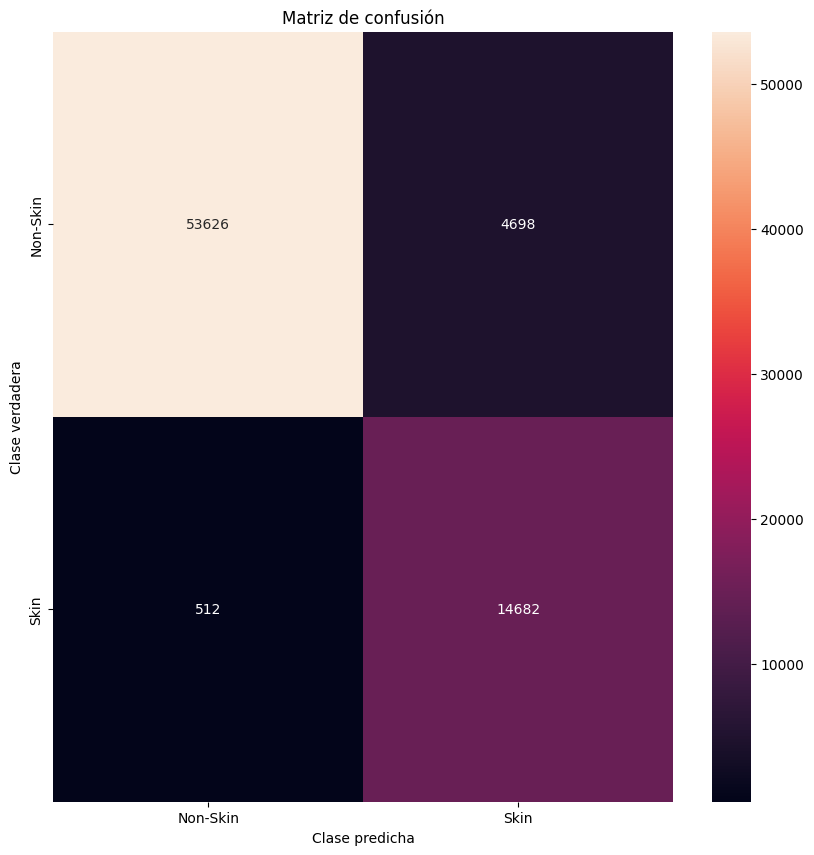

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     58324
           1       0.76      0.97      0.85     15194

    accuracy                           0.93     73518
   macro avg       0.87      0.94      0.90     73518
weighted avg       0.94      0.93      0.93     73518



In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix2, xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="d")
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()
print(classification_report(y_test2,predictions2))

Al aplicar técnica de balanceo de datos se puede apreciar que la capacidad del modelo para predecir non-skin incremento de manera considerable, mientras que la especificidad o capacidad para predecir correctamente un registo skin se ha deteriorado en 0.03 puntos, esto significa que el balanceo no ha surtido un efecto muy significativo respecto a la mejora en la predicción de la clase skin. Si bien aqui el f1 y el accuracy son mayores al escenario 1 es preciso decir que esta mejora no se debe a mejoras en la predicción de la clase minoritaria sino en la clase mayoritaria.

Procedamos a validar estos hallazgos con random subsampling y n-folds

######**Evaluación**


Ahora miremos la evaluación del modelo con Random subsampling y N-Folds.

**Randon Subsampling - Proporciones 70-30**

In [ ]:
def random_subsp_smote(dataset,iteraciones):

    accuracy_scores_list=[]
    confusion_mx_collection=[]
    TP_list=[]
    TN_list=[]
    FP_list=[]
    FN_list=[]
    precision_list=[]
    recall_list=[]
    F1_list=[]
    especificidad_list=[]
    iter_list=range(1,iteraciones+1)

    for element in iter_list:
        print("se inicia la iteración número",element,"\n")
        X_train, X_test, y_train, y_test = train_test_split(dataset.drop('C', axis=1), dataset.C, test_size=0.30)

        smote_tomek = SMOTETomek(sampling_strategy="auto",random_state=54)

        X_train_resamp, y_train_resamp = smote_tomek.fit_resample(X_train,y_train)

        print("En la iteración número",element,f"El dataset de entrenamiento cuenta con {X_train_resamp.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train_resamp.value_counts()[1]} ({round((y_train_resamp.value_counts()[1]/X_train_resamp.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train_resamp.value_counts()[0]} ({round((y_train_resamp.value_counts()[0]/X_train_resamp.shape[0])*100,2)}%)  registros \n")
        print("En la iteración número",element,f"El dataset de test cuenta con {X_test.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test.value_counts()[1]} ({round((y_test.value_counts()[1]/X_test1.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test.value_counts()[0]} ({round((y_test.value_counts()[0]/X_test.shape[0])*100,2)}%)  registros \n")

        reglog= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)
        reglog.fit(X_train_resamp, y_train_resamp)
        predictions = reglog.predict(X_test)

        conf_matrix = confusion_matrix(y_test,predictions)

        TP= conf_matrix[0][0]
        TN= conf_matrix[1][1]
        FP= conf_matrix[0][1]
        FN= conf_matrix[1][0]

        TP_list.append(TP)
        TN_list.append(TN)
        FP_list.append(FP)
        FN_list.append(FN)

        print("La clasificación realizada en esta iteración cuenta con", TP ," Verdadero Positivos", TN, " Verdaderos Negativos", FP," Falsos Positivos y ",FN," Falsos Negativos \n" )

        precision= TP/(TP+FP)
        recall= TP/(TP+FN)
        especificidad = TN/(TN+FP)
        F1= (2*recall*precision)/(recall+precision)

        precision_list.append(precision)
        recall_list.append(recall)
        F1_list.append(F1)
        especificidad_list.append(especificidad)

        print(f"Algunas métricas de la iteracion precision:{precision}, recall: {recall}, especificidad: {especificidad}, F1:{F1} \n")

        accuracy_model = accuracy_score(y_test, predictions)

        confusion_mx_collection.append(conf_matrix)
        accuracy_scores_list.append(accuracy_model)

    scores_array= np.asarray(accuracy_scores_list)
    mean_accu= np.mean(scores_array)
    std_accu= np.std(scores_array)

    TP_avg= np.mean(np.asarray(TP_list))
    TN_avg= np.mean(np.asarray(TN_list))
    FP_avg= np.mean(np.asarray(FP_list))
    FN_avg= np.mean(np.asarray(FN_list))

    conf_matrix_avg= np.array([[TP_avg,FP_avg],[FN_avg,TN_avg]])

    precision_avg= np.mean(np.asarray(precision_list))
    recall_avg= np.mean(np.asarray(recall_list))
    F1_avg= np.mean(np.asarray(F1_list))
    especificidad_avg= np.mean(np.asarray(especificidad_list))

    precision_std= np.std(np.asarray(precision_list))
    recall_std= np.std(np.asarray(recall_list))
    F1_std= np.std(np.asarray(F1_list))
    especificidad_std= np.std(np.asarray(especificidad_list))

    dict_metricas = {"precision":precision_avg,"precision_std":precision_std,"recall avg":recall_avg,"recall_std":recall_std,"specificity_avg":especificidad_avg,
                     "specificity_std":especificidad_std, "accuracy_avg":mean_accu,"accuracy_std":std_accu,"F1_avg":F1_avg,"F1_std":F1_std}

    metrics_resume_avg= pd.DataFrame(data=dict_metricas,index=[0])

    print("Despues de ", iteraciones, " iteraciones el accuracy promedio es de",mean_accu, " y su desviación estándar es de + o - ",std_accu)

    tupla_final= (conf_matrix_avg,metrics_resume_avg,precision_avg,precision_std,recall_avg,recall_std,precision_std,F1_avg,F1_std,especificidad_avg,especificidad_std,mean_accu,std_accu)

    return tupla_final

In [ ]:
evaluacion_metodo2 = random_subsp_smote(skin_corr_df,10)

se inicia la iteración número 1 

En la iteración número 1 El dataset de entrenamiento cuenta con 271904 registros y con una distribución de clases en donde 1 corresponde a 135952 (50.0%) registros y la clase 0 corresponde a 135952 (50.0%)  registros 

En la iteración número 1 El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15274 (20.78%) registros y la clase 0 corresponde a 58244 (79.22%)  registros 

La clasificación realizada en esta iteración cuenta con 53549  Verdadero Positivos 14708  Verdaderos Negativos 4695  Falsos Positivos y  566  Falsos Negativos 

Algunas métricas de la iteracion precision:0.919390838541309, recall: 0.9895407927561675, especificidad: 0.758027109209916, F1:0.9531768705666659 

se inicia la iteración número 2 

En la iteración número 2 El dataset de entrenamiento cuenta con 272250 registros y con una distribución de clases en donde 1 corresponde a 136125 (50.0%) registros y la clase 0 corresponde a 1361

Una vez aplicado el random subsampling se procede a generar la matriz de confusión promedio del proceso iterativo de evaluación:

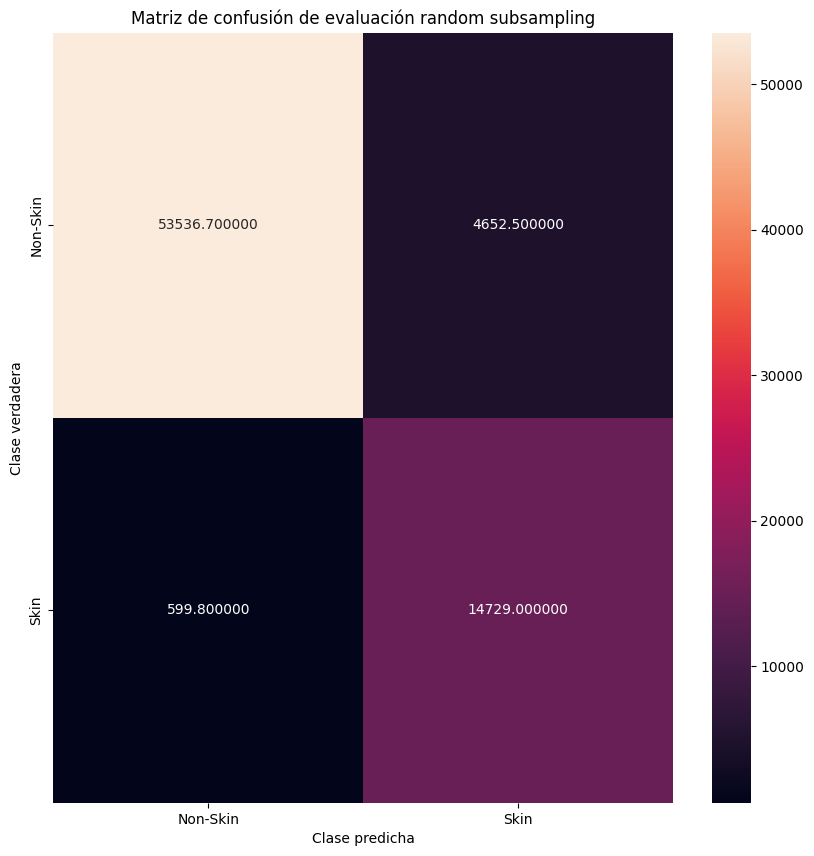

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(evaluacion_metodo2[0], xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="f")
plt.title("Matriz de confusión de evaluación random subsampling")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

In [ ]:
evaluacion_metodo2[1]

,precision,precision_std,recall avg,recall_std,especificity_avg,specificity_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.920045,0.000789,0.988921,0.000608,0.759946,0.00257,0.928558,0.000727,0.95324,0.000472


Al ejecutar las 10 iteraciones de random subsampling se puede apreciar que los valores de las métricas se mantienen cercanas a los valores del modelo con semilla aleatoria.  

**N-Folds Validation**

Ahora, se realiza la validación con N-Folds y 10 splits

In [ ]:
X2= skin_corr_df[["R","G","B"]]
y2= skin_corr_df["C"]


smote_tomek = SMOTETomek(sampling_strategy="auto",random_state=54)
X_resamp, y_resamp = smote_tomek.fit_resample(X2,y2)

reglog2= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)

evaluation_kfold2 = cross_validation(reglog2, X_resamp, y_resamp, _cv=10)


In [ ]:
evaluation_kfold2

,precision,precision_std,recall avg,recall_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.923124,0.040473,0.959577,0.031296,0.939245,0.032362,0.940657,0.031534


Con este medio de validación cruzada, teniendo 10 splits, se obtiene un accuracy inferior y un f1 menor, lo cual indica que ante variabilidad en los datos de entrenamiento y test el modelo tiende a tener leves desmejoras respecto a su capacidad inicial de clasificación. Asi las cosas, el modelo inicial con semilla aleatoria y el randomsubsampling inflan hasta cierto punto la capacidad de clasificación, sin embargo no se evidencian mejoras en la especificidad.

Ahora, se procede a realizar el siguiente escenario con datos correlacionados pero sin balancear.

##### **Escenario 3 - Regresión Logistica con eliminación de datos correlacionados y sin balanceo**

Ahora se procede a dividir el set de datos en el conjunto de entrenamiento y de prueba para el modelo.





In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(skin_no_corr_df.drop('C', axis=1), skin_no_corr_df.C, test_size=0.30,random_state=42)

print(f"El dataset de entrenamiento cuenta con {X_train3.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train3.value_counts()[1]} ({round((y_train3.value_counts()[1]/X_train3.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train3.value_counts()[0]} ({round((y_train3.value_counts()[0]/X_train3.shape[0])*100,2)}%)  registros \n")

print(f"El dataset de test cuenta con {X_test3.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test3.value_counts()[1]} ({round((y_test3.value_counts()[1]/X_test3.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test3.value_counts()[0]} ({round((y_test3.value_counts()[0]/X_test3.shape[0])*100,2)}%)  registros \n")


El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35665 (20.79%) registros y la clase 0 corresponde a 135874 (79.21%)  registros 

El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15194 (20.67%) registros y la clase 0 corresponde a 58324 (79.33%)  registros 



En este punto, se entrena el modelo del escenario 3 y se elabora la matriz de confusión de este.



In [ ]:
#Entrenamiento del modelo
logisticRegr3= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01,random_state=42)
logisticRegr3.fit(X_train3, y_train3)

#Predicción usando el modelo
predictions3 = logisticRegr3.predict(X_test3)

## Matriz de confusión
conf_matrix3 = confusion_matrix(y_test3,predictions3)

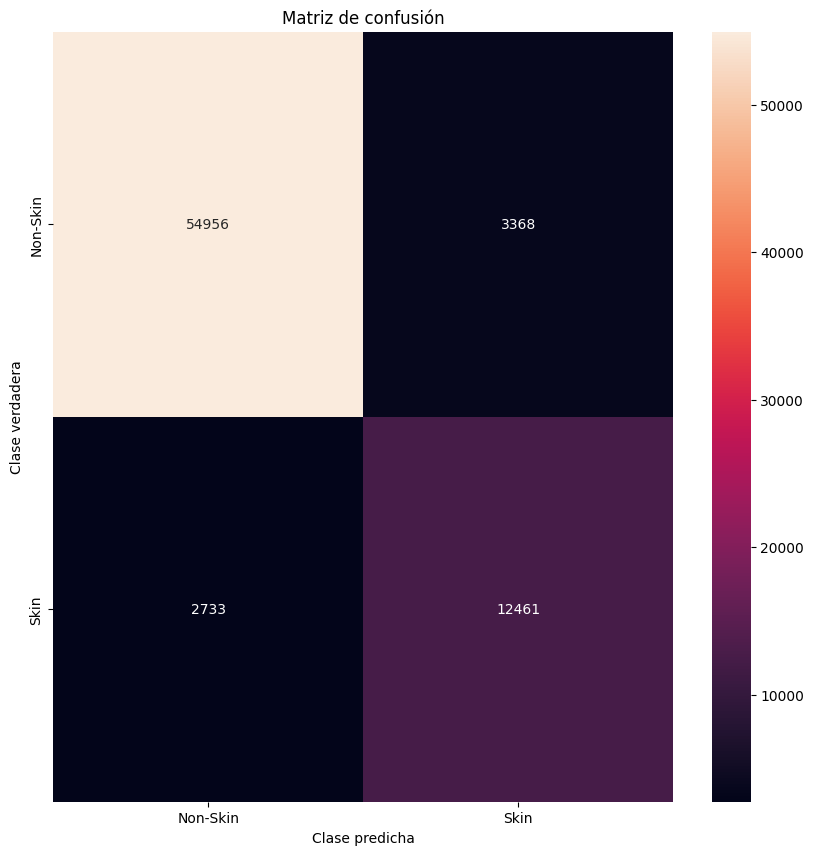

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     58324
           1       0.79      0.82      0.80     15194

    accuracy                           0.92     73518
   macro avg       0.87      0.88      0.88     73518
weighted avg       0.92      0.92      0.92     73518



In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix3, xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="d")
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()
print(classification_report(y_test3,predictions3))

En este caso con eliminación de datos correlacioados se puede apreciar que respecto al caso con balanceo hay mejoras, no obstante tales mejoras no superan el limite del primer escenario, en este caso la especificidad continua en 0.79 y se presenta un nivel de F1 y accuracy igual al del primer escenario. Esto conlleva a plantar que posiblemente la eliminación de datos correlacionados no resulta ser una transformación que contribuya positivamente a la mejora del desemepeño del modelo.


######**Evaluación**

Ahora miremos la evaluación del modelo con Random subsampling y N-Folds.

**Random Subsampling 70-30**

A continuación, se realiza la evaluación con el random subsampling.

In [ ]:
evaluacion_metodo3 = random_subsp(skin_no_corr_df,10)

se inicia la iteración número 1 

En la iteración número 1 El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35800 (20.87%) registros y la clase 0 corresponde a 135739 (79.13%)  registros 

En la iteración número 1 El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15059 (20.48%) registros y la clase 0 corresponde a 58459 (79.52%)  registros 

La clasificación realizada en esta iteración cuenta con 55121  Verdadero Positivos 12337  Verdaderos Negativos 3338  Falsos Positivos y  2722  Falsos Negativos 

Algunas métricas de la iteracion precision:0.9429001522434527, recall: 0.9529415832512145, especificidad: 0.7870494417862839, F1:0.9478942752489209 

se inicia la iteración número 2 

En la iteración número 2 El dataset de entrenamiento cuenta con 171539 registros y con una distribución de clases en donde 1 corresponde a 35510 (20.7%) registros y la clase 0 corresponde a 1

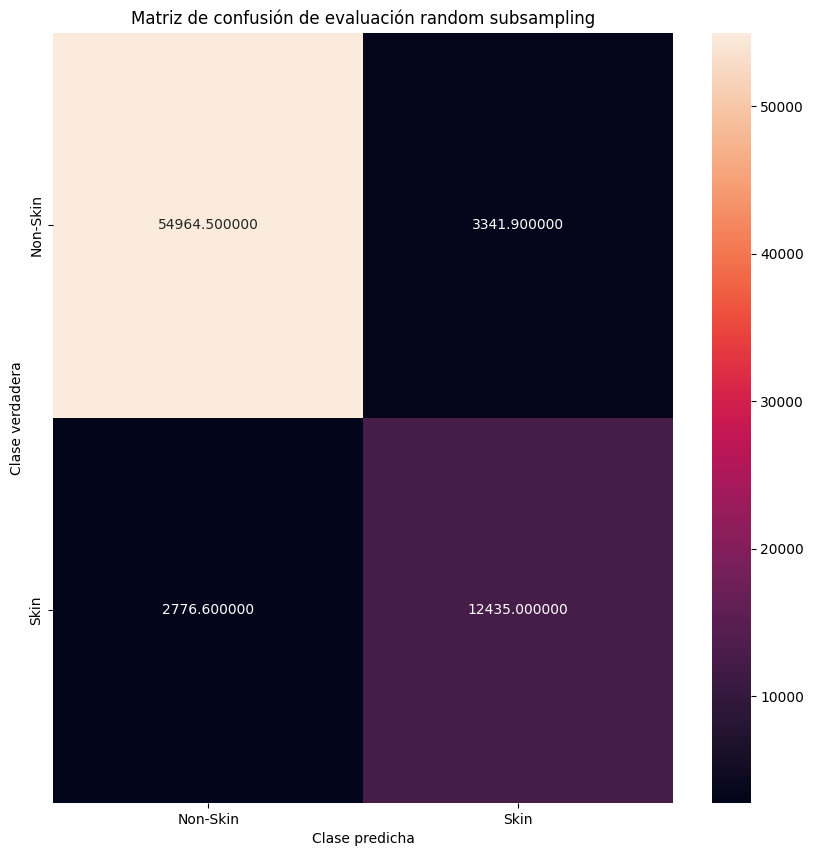

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(evaluacion_metodo3[0], xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="f")
plt.title("Matriz de confusión de evaluación random subsampling")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

In [ ]:
evaluacion_metodo3[1]

,precision,precision_std,recall avg,recall_std,especificity_avg,specificity_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.942684,0.00059,0.951914,0.001072,0.788177,0.001662,0.916775,0.000776,0.947276,0.000515


Al revisar las métricas promedio obtenidas es posible apreciar que de conformidad a este método de evalaución efectivamente el cambio de escenario en términos de preparación de datos no esta generando un efecto significativo, sino que por el contrario se tiene un modelo con las mismas capacidades de clasificación que el modelo 1 manteniendo una especificidad de 0.79 y niveles superiores para la clase "non-skin".

**N-Folds Validation**

Ahora, se realiza la validación con N-Folds y 10 splits

In [ ]:
X3= skin_no_corr_df[["R","B"]]
y3= skin_no_corr_df["C"]

reglog3= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)

evaluation_kfold3 = cross_validation(reglog3, X3, y3, _cv=10)


In [ ]:
evaluation_kfold3

,precision,precision_std,recall avg,recall_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.797556,0.145762,0.800904,0.197759,0.912743,0.052672,0.78513,0.136956


Al revisar esta evaluación con n_folds es posible apreciar que efectivamente el modelo tiene problemas para generalizar los resultados y se v influido negativamente por el desbalance de clases, en cierta manera se puede apreciar que el balanceo de clases es mucho más influyente en el desempeño que la remoción de datos altamente correlacionados.



##### **Escenario 4 - Regresión Logistica con eliminación de datos correlacionados y con balanceo**

Ahora se procede a dividir el set de datos en el conjunto de entrenamiento y de prueba para el modelo.

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(skin_no_corr_df.drop('C', axis=1), skin_no_corr_df.C, test_size=0.30,random_state=42)

smote_tomek = SMOTETomek(sampling_strategy="auto",random_state=42)
X_train4_resamp, y_train4_resamp = smote_tomek.fit_resample(X_train4,y_train4)

print(f"El dataset de entrenamiento cuenta con {X_train4_resamp.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_train4_resamp.value_counts()[1]} ({round((y_train4_resamp.value_counts()[1]/X_train4_resamp.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_train4_resamp.value_counts()[0]} ({round((y_train4_resamp.value_counts()[0]/X_train4_resamp.shape[0])*100,2)}%)  registros \n")

print(f"El dataset de test cuenta con {X_test4.shape[0]} registros y con una distribución de clases en donde 1 corresponde a {y_test4.value_counts()[1]} ({round((y_test4.value_counts()[1]/X_test4.shape[0])*100,2)}%) registros y la clase 0 corresponde a {y_test4.value_counts()[0]} ({round((y_test4.value_counts()[0]/X_test4.shape[0])*100,2)}%)  registros \n")


El dataset de entrenamiento cuenta con 271722 registros y con una distribución de clases en donde 1 corresponde a 135861 (50.0%) registros y la clase 0 corresponde a 135861 (50.0%)  registros 

El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15194 (20.67%) registros y la clase 0 corresponde a 58324 (79.33%)  registros 



En este punto, se entrena el modelo del escenario 4 y se elabora la matriz de confusión de este.

In [ ]:
#Entrenamiento del modelo
logisticRegr4= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01,random_state=42)
logisticRegr4.fit(X_train4_resamp, y_train4_resamp)

#Predicción usando el modelo
predictions4 = logisticRegr4.predict(X_test4)

## Matriz de confusión
conf_matrix4 = confusion_matrix(y_test4,predictions4)

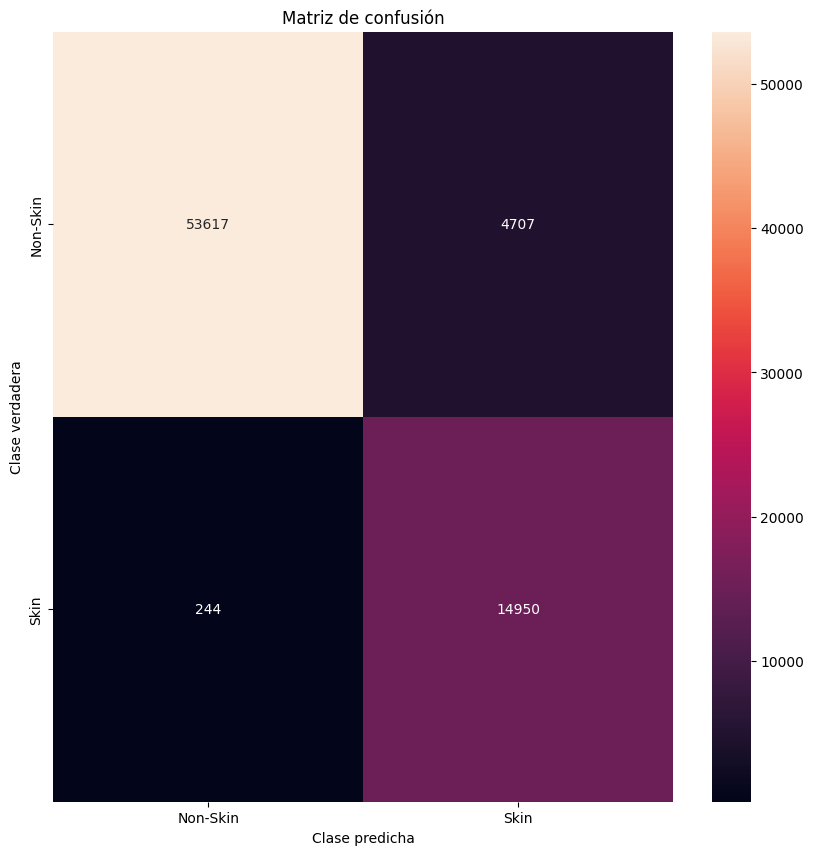

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     58324
           1       0.76      0.98      0.86     15194

    accuracy                           0.93     73518
   macro avg       0.88      0.95      0.91     73518
weighted avg       0.95      0.93      0.94     73518



In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix4, xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="d")
plt.title("Matriz de confusión")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()
print(classification_report(y_test4,predictions4))

Al apreciar el resultado obtenido puede evidenciarse que el balanceo por medio de SMOTE_Tomek al ser aplicado cuando se han eliminado datos altamente correlacionados es mucho más severo respecto a la mejora en la predicción de la clase non-skin, y no genera cambios relevantes en la especificidad, asi las cosas, al aplicar ambas transformaciones el modelo ha mejorado su capacidad de para clasificar "non-skin" y ha mantenido su margen de error para clasificar clases "skin". Particularmente en este caso el f1 aumenta por cuenta de la clase "non-skin".

######**Evaluación**

Ahora miremos la evaluación del modelo con Random subsampling y N-Folds.

**Random Subsampling 70-30**

A continuación, se realiza la evaluación con el random subsampling.

In [ ]:
metodo_evaluacion4= random_subsp_smote(skin_no_corr_df,10)

se inicia la iteración número 1 

En la iteración número 1 El dataset de entrenamiento cuenta con 271548 registros y con una distribución de clases en donde 1 corresponde a 135774 (50.0%) registros y la clase 0 corresponde a 135774 (50.0%)  registros 

En la iteración número 1 El dataset de test cuenta con 73518 registros y con una distribución de clases en donde 1 corresponde a 15119 (20.57%) registros y la clase 0 corresponde a 58399 (79.43%)  registros 

La clasificación realizada en esta iteración cuenta con 53661  Verdadero Positivos 14713  Verdaderos Negativos 4738  Falsos Positivos y  406  Falsos Negativos 

Algunas métricas de la iteracion precision:0.9188684737752358, recall: 0.9924907984537703, especificidad: 0.7564135520024677, F1:0.9542617324346914 

se inicia la iteración número 2 

En la iteración número 2 El dataset de entrenamiento cuenta con 271720 registros y con una distribución de clases en donde 1 corresponde a 135860 (50.0%) registros y la clase 0 corresponde a 13

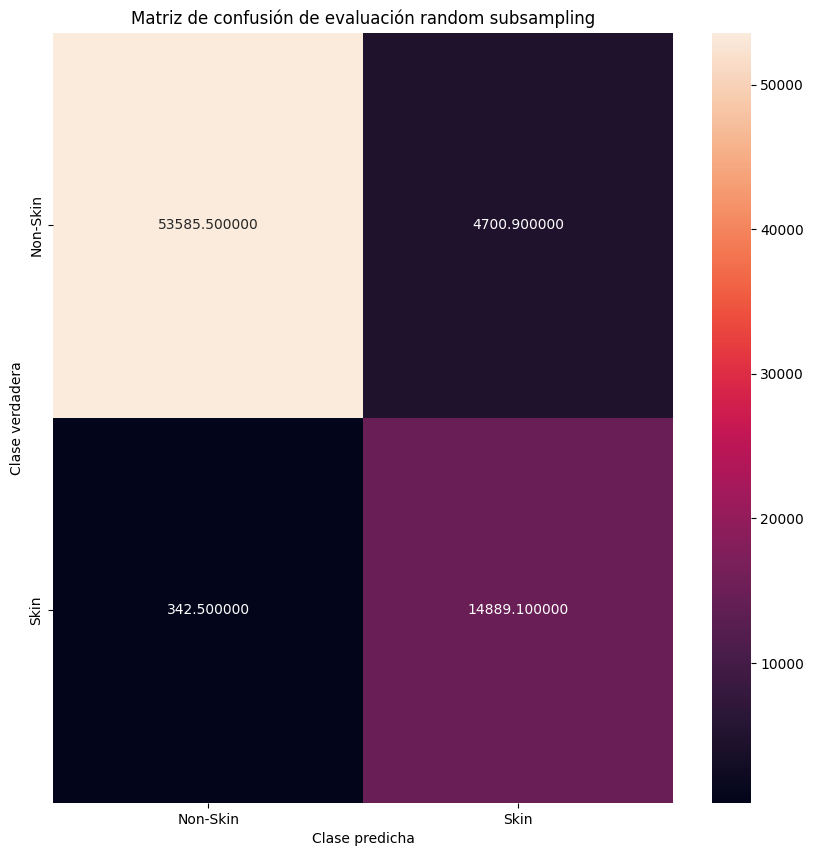

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(metodo_evaluacion4[0], xticklabels=["Non-Skin","Skin"],yticklabels=["Non-Skin","Skin"],annot=True,fmt="f")
plt.title("Matriz de confusión de evaluación random subsampling")
plt.ylabel("Clase verdadera")
plt.xlabel("Clase predicha")
plt.show()

In [ ]:
metodo_evaluacion4[1]

,precision,precision_std,recall avg,recall_std,especificity_avg,specificity_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.919349,0.000772,0.99365,0.00071,0.760029,0.002841,0.931399,0.000708,0.955056,0.00041


Al revisar random subsampling el panorama de las métricas no varia mucho, el valor alto de recall persiste, no obstante se logra apreciar que la precision equivalente a 1 resulta estar inflada y resulta ser mucho menor en promedio, no obstante las demás métricas conservan lineas de valor muy similares.

**N-folds Validation**

Ahora, se realiza la validación con N-Folds y 10 splits

In [ ]:
X4= skin_no_corr_df[["R","B"]]
y4= skin_no_corr_df["C"]


smote_tomek4 = SMOTETomek(sampling_strategy="auto",random_state=54)
X_resamp4, y_resamp4 = smote_tomek4.fit_resample(X4,y4)


reglog4= LogisticRegression(solver="lbfgs", max_iter=500, tol=0.01)

evaluation_kfold4 = cross_validation(reglog4,X_resamp4,y_resamp4, _cv=10)



In [ ]:
evaluation_kfold4

,precision,precision_std,recall avg,recall_std,accuracy_avg,accuracy_std,F1_avg,F1_std
0,0.924648,0.038504,0.972932,0.028644,0.94623,0.030032,0.947837,0.029087


Con este medio de evaluación se puede apreciar que al iterar sobre varios splits la precision y el recall siguen al alza mientras el f1 se deteriora respecto al random_subsampling, esto permite demarcar que comparativamente esta versión del modelo resalta frente a las demás sin embargo es importante precisar que:

- La eliminación de datos altamente correlacionados y el balanceo usando subsampling y oversampling no estan impactando de manera significativa la especificidad o capacidad del modelo para predecir los registros "skin".

- Ante esto resulta conveniente explorar técnicas puras se oversampling y subsampling sobre los training sets para ver si por medio de ellas se logra un impactos en la capacidad de clasificación del modelo respecto a reigstros relacionados a piel (skin).



#### **Conclusiones**

El conjunto de escenarios probados a lo largo de este notebook se pueden ver resumidos en la siguiente tabla:

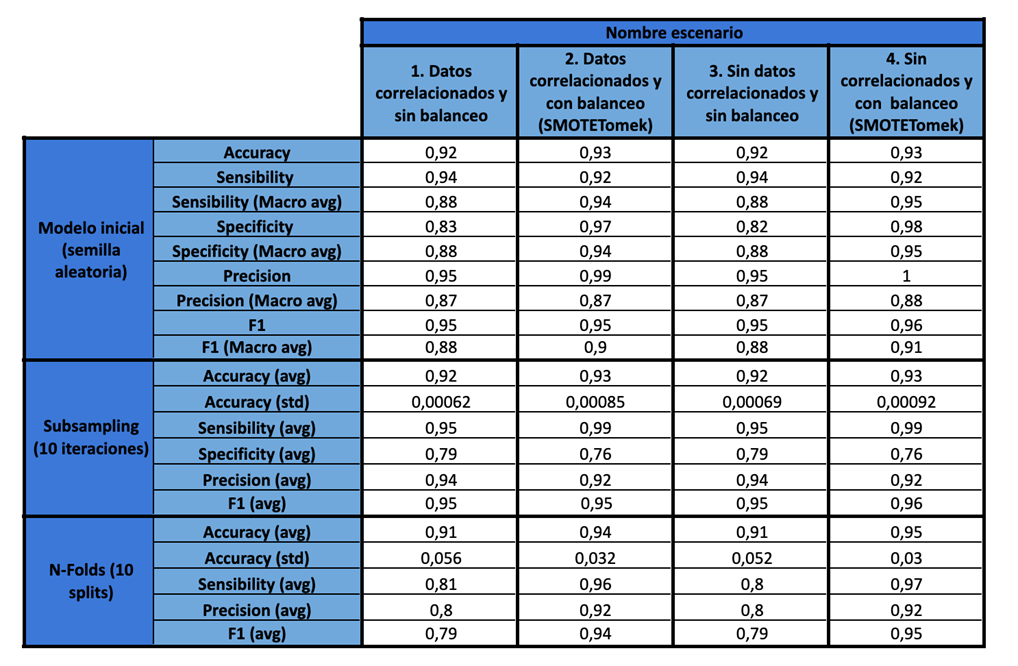

En esta tabla, es posible observar en términos generales, que los escenarios que tienen un mejor comportamiento, son aquellos en los que se realiza un balanceo de los datos (escenario 2 y 4). En el modelo inicial, estos escenarios tuvieron un accuracy levemente superior y un mejor desempeño en cada una de las métricas (sensibilidad, especificidad, precisión y F1-Score).

En cuanto a la evaluación con Random Subsampling, estos escenarios también tienen un mejor desempeño en casi todas las métricas, aunque existen diferencias relevantes en dos de ellas. Por un lado, en términos de sensibilidad, los modelos con balanceo tienen un desempeño mejor que los sin balanceo de +0.04. Por otro lado, en la métrica en la que si presenta una reducción en el desempeño, es en la de especificidad de -0.03. En esta medición específica, los escenarios sin balanceo tienen un mejor comportamiento.

Por su parte, en cuanto a la validación cruzada con N-Folds, estos escenarios también demostraron tener un mejor desempeño en cada una de las métricas.

Los puntos anteriormente mencionados tiene especial relevancia dentro de la “generalidad” del modelo, no obstante al apreciar métricas relevantes como la especificidad se puede apreciar que esta aun así con el balanceo y la remoción de datos correlacionados no tuvo grandes mejoras, en el marco del desarrollo de este ejercicio sklearn tomo como clase negativa a “skin” en este caso al ser clase minoritaria se puede observar que a pesar las transformaciones el limite de poder de clasificación fue de 0.79 en especificidad, de resto las mejoras del modelo en accuracy y otras métricas están fuertemente influidas por mejoras en el poder de clasificación en las clases non-skin. Así las cosas, esta revisión un poco más critica de las medidas conduce a decir que:

-	La eliminación de datos altamente correlacionados y el balanceo usando subsampling y oversampling por medio de técnicas como SMOTETomek no estan impactando de manera significativa la especificidad o capacidad del modelo para predecir los registros "skin".

-	Ante esto resulta conveniente explorar técnicas puras se oversampling y subsampling sobre los training sets para ver si por medio de ellas se logra un impacto en la capacidad de clasificación del modelo respecto a reigstros relacionados a piel (skin).

En resumen, este ejercicio permite mostrar la importancia de realizar análisis con distintas métricas de evaluación del aprendizaje. Observando los pro y contras de los distintos modelos. Lo que permite observar desde distintas ópticas el desempeño de los modelos. En este caso particular con este set de datos, se evidencia la importancia de entrenar los modelos con datos balanceados.
